# Gonads - sn/sc alignement via Log regression

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from sklearn.linear_model import LogisticRegression

def MovePlots(plotpattern, subplotdir):
    if not os.path.exists(sc.settings.figdir+subplotdir):
        os.makedirs(sc.settings.figdir+subplotdir)
    os.system('mv '+sc.settings.figdir+'*'+plotpattern+'*.* '+sc.settings.figdir+'/'+subplotdir)

    
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/LR_male/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
backcall            0.2.0
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.2.1
igraph              0.9.0
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.36.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.0
numexpr             2.7.3
numpy               1.20.1
packaging           20.9
pandas              1.2.3
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.17
psutil              5.8.0
ptyprocess          0.7.0
pyexpat             NA
pygments            2.8.1
pyparsin

'/home/jovyan/my-conda-envs/palantir/bin/python'

## Load scRef data

In [3]:
# sc_adataP = sc.read('data/sns-all-TC-keep-ccg_forSeurat.h5ad')
# NOTE: We're loading raw counts, we're fine!
sc_adataP = sc.read('/nfs/team292/lg18/with_valentina/FCA2sex-M5-annotatedClusters.h5ad')

KeyboardInterrupt: 

In [ ]:
sc_adataP.var.index = [ i.decode("utf-8") for i in sc_adataP.var.index ]
sc_adataP.raw.var.index = [ i.decode("utf-8") for i in sc_adataP.raw.var.index ]

sc_adataP.obs.index = [ i.decode("utf-8") for i in sc_adataP.obs.index ]
sc_adataP.obs['clusters'] = [ i.decode("utf-8") for i in sc_adataP.obs['clusters'] ]
sc_adataP.obs['sex'] = [ i.decode("utf-8") for i in sc_adataP.obs['sex'] ]

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sex' as categorical
... storing 'clusters' as categorical


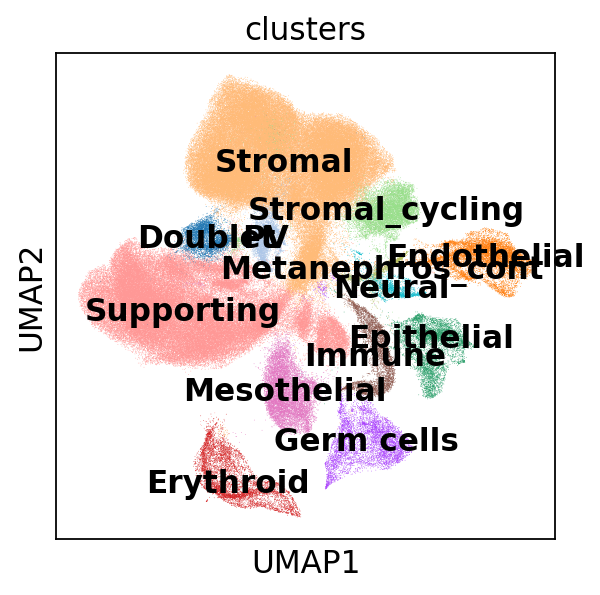

In [4]:
sc.pl.umap(sc_adataP, color='clusters', legend_loc='on data')

In [5]:
sc_adataP = sc_adataP[[ 'male' in i for i in sc_adataP.obs['sex'] ]]
sc_adataP = sc_adataP[[ 12==i for i in sc_adataP.obs['PCW'] ]]
sc_adataP = sc_adataP[[ 'Doublet' not in i for i in sc_adataP.obs['clusters'] ]]
sc_adataP = sc_adataP[[ 'Metanephros_cont' not in i for i in sc_adataP.obs['clusters'] ]]
sc_adataP = sc_adataP[[ 'Neural' not in i for i in sc_adataP.obs['clusters'] ]]

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


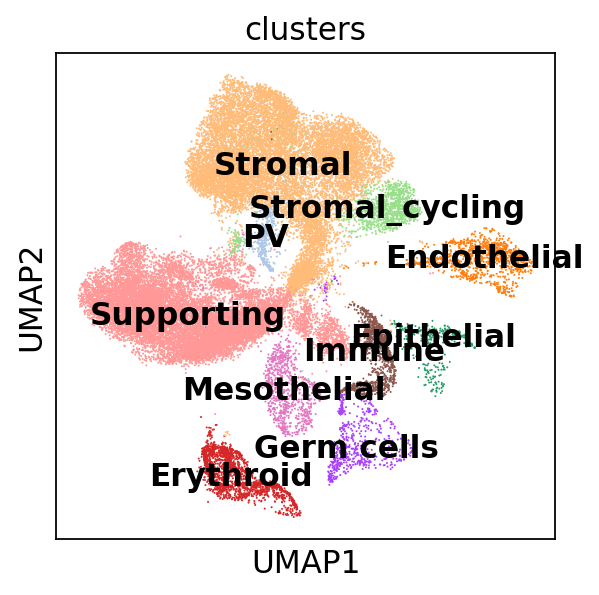

In [6]:
sc.pl.umap(sc_adataP, color='clusters', legend_loc='on data')

In [7]:
sc_adata = anndata.AnnData(X=sc_adataP.raw.X, var=sc_adataP.raw.var, obs=sc_adataP.obs, asview=False)
sc.pp.filter_genes(sc_adata, min_cells=5)
sc.pp.normalize_per_cell(sc_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata)
highly_variable_genes = sc_adata.var["highly_variable"]
sc_adata = sc_adata[:, highly_variable_genes]
sc.pp.scale(sc_adata, max_value=10)

sc_adata.obsm["X_umap"] = sc_adataP.obsm["X_umap"]

filtered out 4798 genes that are detected in less than 5 cells
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Load single nuclei

In [4]:
sn_adataR = sc.read('FCAsn-M3denoised_clusters_male.h5ad')

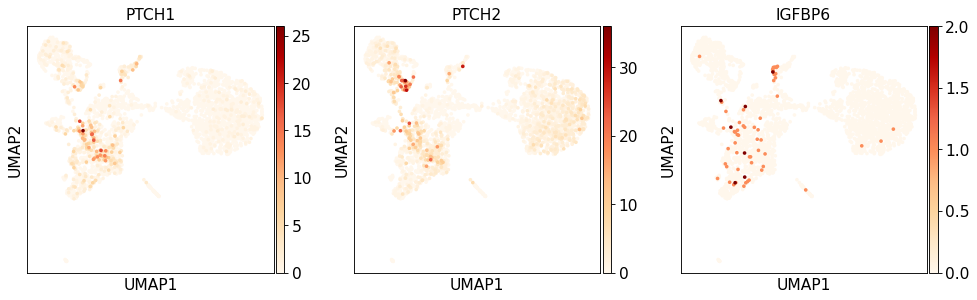

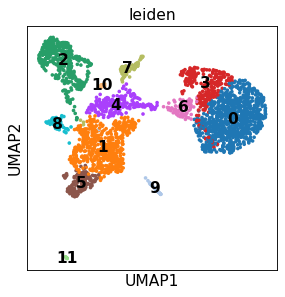

In [10]:
sc.pl.umap(sn_adataR, color=['PTCH1', 'PTCH2', 'IGFBP6'], color_map='OrRd', use_raw=True)
sc.pl.umap(sn_adataR, color=['leiden'], legend_loc='on data')

In [5]:
sn_adataR.var.index = [ i.decode("utf-8") for i in sn_adataR.var.index ]
sn_adataR.raw.var.index = [ i.decode("utf-8") for i in sn_adataR.raw.var.index ]

sn_adataR.obs.index = [ i.decode("utf-8") for i in sn_adataR.obs.index ]
sn_adataR.obs['leiden'] = [ i.decode("utf-8") for i in sn_adataR.obs['leiden'] ]

AttributeError: 'str' object has no attribute 'decode'

filtered out 4455 genes that are detected in less than 5 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


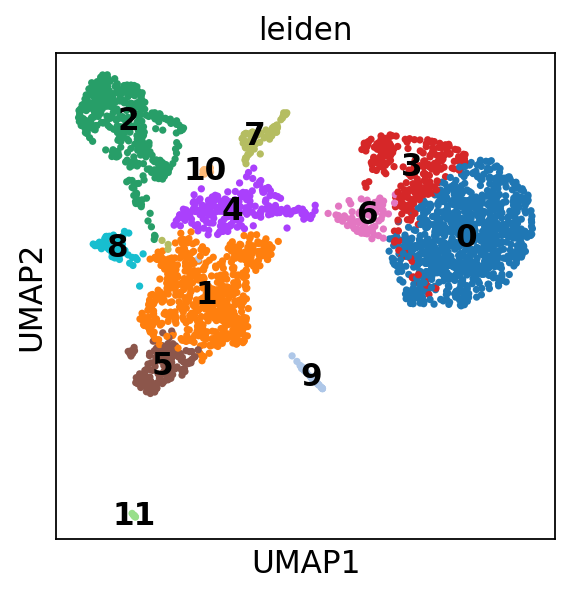

In [10]:
# NOTE: we're loading log-transformed counts, so revert them to raw counts
sn_adata = anndata.AnnData(X=sn_adataR.raw.X, var=sn_adataR.raw.var, obs=sn_adataR.obs, asview=False)
sn_adata.obsm["X_umap"] = sn_adataR.obsm["X_umap"]

# sn_adata = sn_adata[[ i not in ['1'] for i in sn_adata.obs['leiden'] ]]
sc.pp.filter_genes(sn_adata, min_cells=5)
sc.pp.normalize_per_cell(sn_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sn_adata)
sc.pp.highly_variable_genes(sn_adata)#min_mean=0.0125, min_disp=0.25)
highly_variable_genes = sn_adata.var["highly_variable"]
sn_adata = sn_adata[:, highly_variable_genes]
sc.pp.scale(sn_adata, max_value=10)


sc.pl.umap(sn_adata, color='leiden', legend_loc='on data')

## Filter common genes

In [11]:
common_genes = list(set(sc_adata.var.index.values).intersection(sn_adata.var.index.values))
print('common genes: ', len(common_genes))
sn_adata = sn_adata[:,common_genes]
sc_adata = sc_adata[:,common_genes]
print(sc_adata.X.shape)
print(sn_adata.X.shape)

common genes:  957
(37012, 957)
(2822, 957)


### Build a regression classifier from the sn

In [12]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(sc_adata.X, [str(i) for i in sc_adata.obs['clusters'].values])

LogisticRegression(C=0.2, max_iter=10000, n_jobs=-1, random_state=0)

### Classify





In [13]:
predictions = logisticRegr.predict(sn_adata.X)
sn_adata.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(sn_adata.X)
probs_adata = []
for i,clus in enumerate(sn_adata.obs['predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, copying.


## Plot classification

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'predictions' as categorical


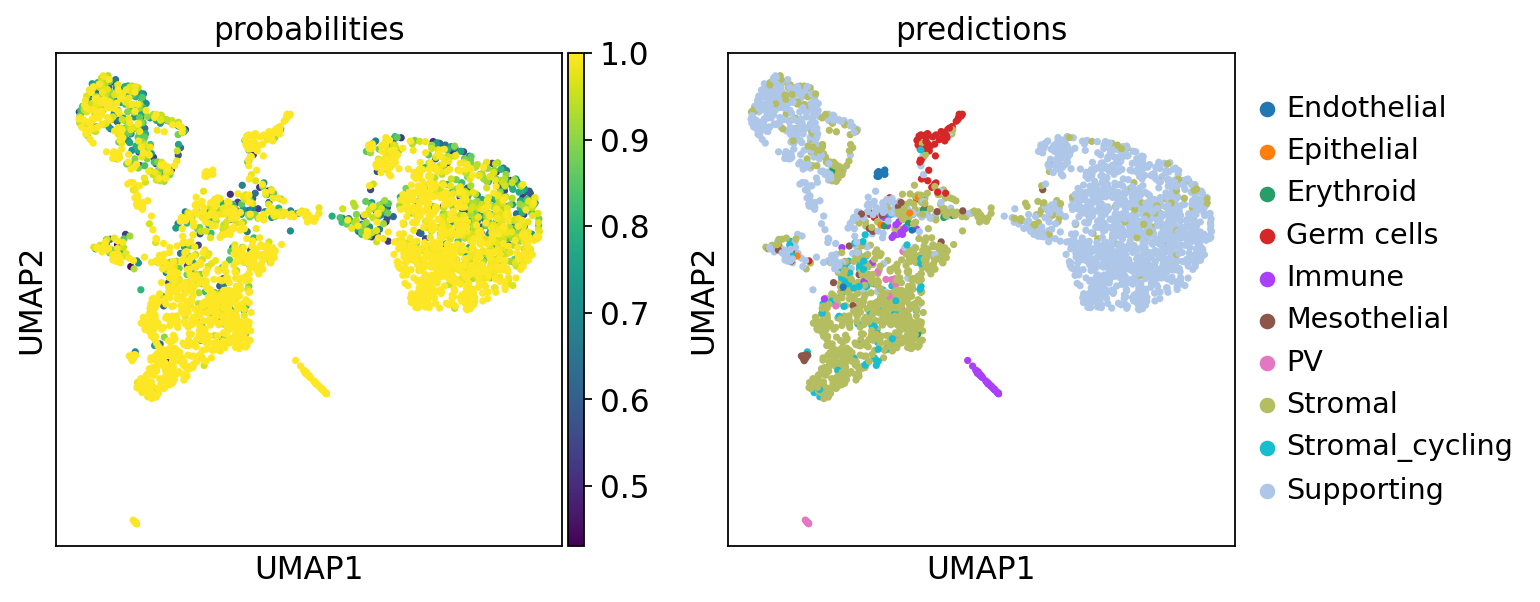

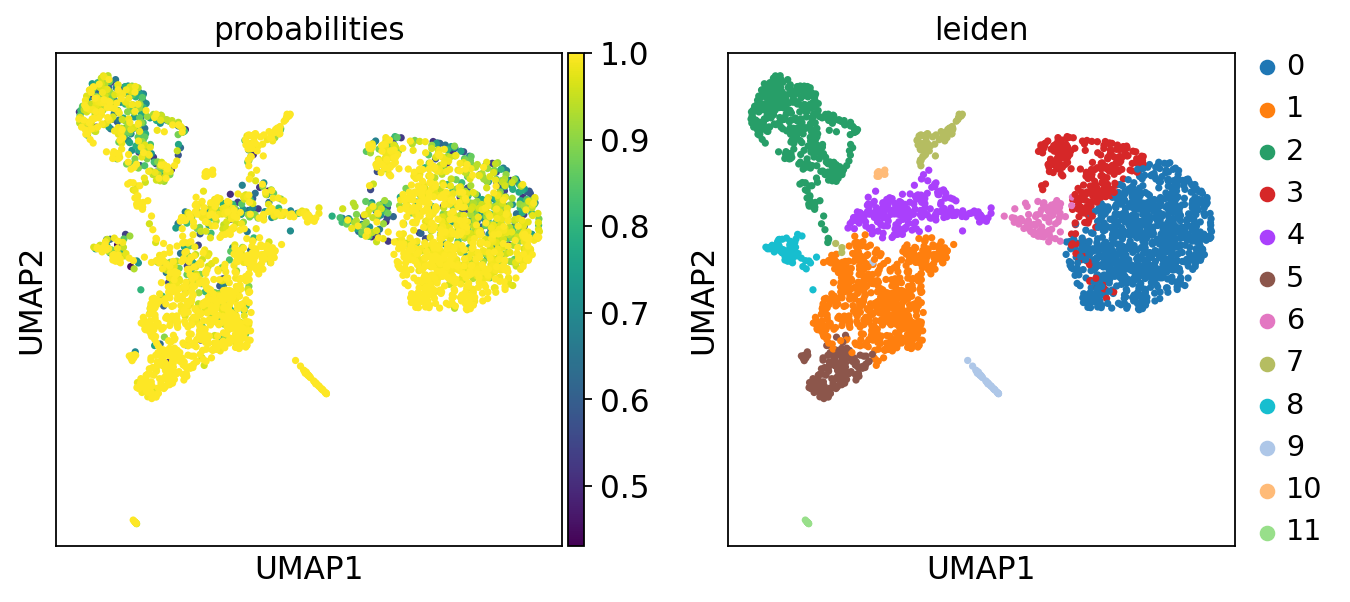

In [14]:
sn_adata.obs['probabilities'] = probs_adata
sc.pl.umap(sn_adata, color=['probabilities',  'predictions'])
sc.pl.umap(sn_adata, color=['probabilities',  'leiden'])

# Zoom in into mesenchymal

In [15]:
# meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_annotated.csv')
# meta_som = meta_som.set_index('Unnamed: 0')
# meta_som.head()

# meta_germ = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotated.csv')
# meta_germ = meta_germ.set_index('Unnamed: 0')
# meta_germ.head()

meta_mes = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymalPV_annotated.csv')
meta_mes = meta_mes.set_index('Unnamed: 0')
meta_mes.head()
mes_cell_annot = meta_mes['annotated_clusters'].to_dict()

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


filtered out 9288 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clusters' as categorical


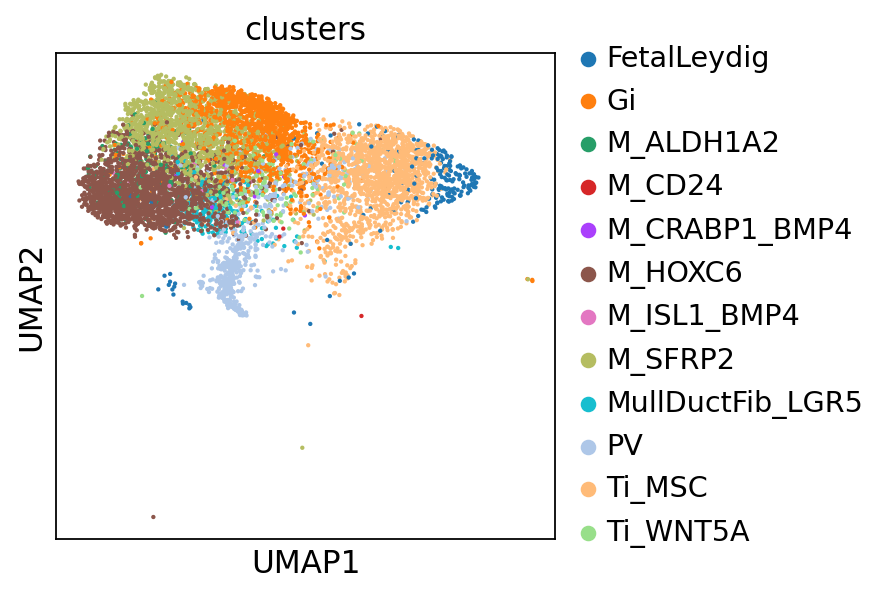

In [16]:
# Subset scRNAref to clusters of interest
sc_adata = anndata.AnnData(X=sc_adataP.raw.X, var=sc_adataP.raw.var, obs=sc_adataP.obs, asview=False)
sc_adata.obsm["X_umap"] = sc_adataP.obsm["X_umap"]

barcodes = meta_mes.index.tolist()
sc_adata = sc_adata[[ i in barcodes for i in sc_adata.obs.index]]
sc_adata.obs['clusters'] = sc_adata.obs['clusters'].tolist()
sc_adata.obs['clusters'] = [ mes_cell_annot[i] for i in sc_adata.obs_names ] 
sc_adata = sc_adata[[ 'Oi_STAR' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'Stromal' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'doublet' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'cycling' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'lowQC' not in i for i in sc_adata.obs['clusters'] ]]

sc.pp.filter_genes(sc_adata, min_cells=5)
sc.pp.normalize_per_cell(sc_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata)
highly_variable_genes = sc_adata.var["highly_variable"]
sc_adata = sc_adata[:, highly_variable_genes]
sc.pp.scale(sc_adata, max_value=10)

sc.pl.umap(sc_adata, color='clusters')

In [24]:
# Subset snRNA to clusters of interest
sn_adata = anndata.AnnData(X=sn_adataR.raw.X, var=sn_adataR.raw.var, obs=sn_adataR.obs, asview=False)
sn_adata.obsm["X_umap"] = sn_adataR.obsm["X_umap"]
sn_adata = sn_adata[[ i in ['1', '2', '4', '5', '8', '11'] for i in sn_adata.obs['leiden'] ]]
sc.pp.filter_genes(sn_adata, min_cells=5)
sc.pp.normalize_per_cell(sn_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sn_adata)
sc.pp.highly_variable_genes(sn_adata)#min_mean=0.0125, min_disp=0.25)
highly_variable_genes = sn_adata.var["highly_variable"]
sn_adata = sn_adata[:, highly_variable_genes]
sc.pp.scale(sn_adata, max_value=10)

filtered out 7607 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:
common_genes = list(set(sc_adata.var.index.values).intersection(sn_adata.var.index.values))
print('common genes: ', len(common_genes))
sn_adata = sn_adata[:,common_genes]
sc_adata = sc_adata[:,common_genes]
print(sc_adata.X.shape)
print(sn_adata.X.shape)

common genes:  576
(7921, 576)
(1453, 576)


### Build a regression classifier from the sn

In [26]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(sc_adata.X, [str(i) for i in sc_adata.obs['clusters'].values])

LogisticRegression(C=0.2, max_iter=10000, n_jobs=-1, random_state=0)

### Classify





In [27]:
predictions = logisticRegr.predict(sn_adata.X)
sn_adata.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(sn_adata.X)
probs_adata = []
for i,clus in enumerate(sn_adata.obs['predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, copying.


## Plot classification

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical
... storing 'predictions' as categorical


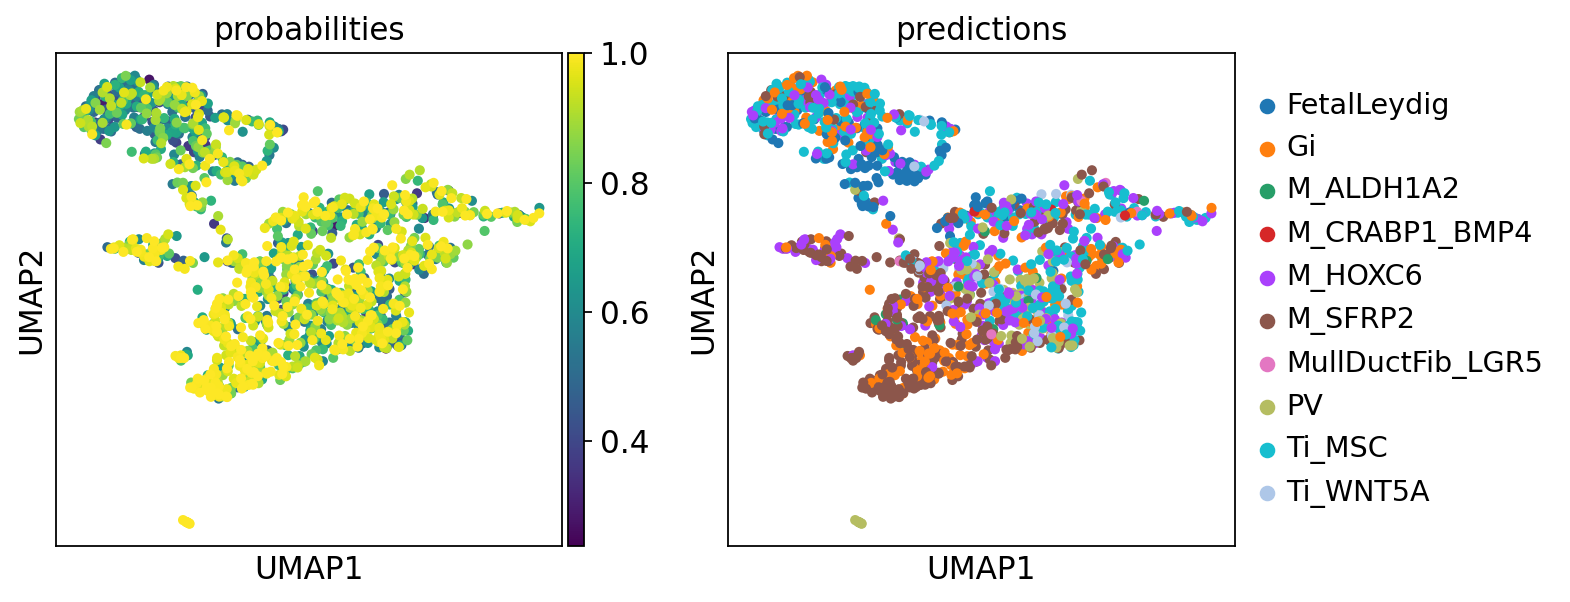

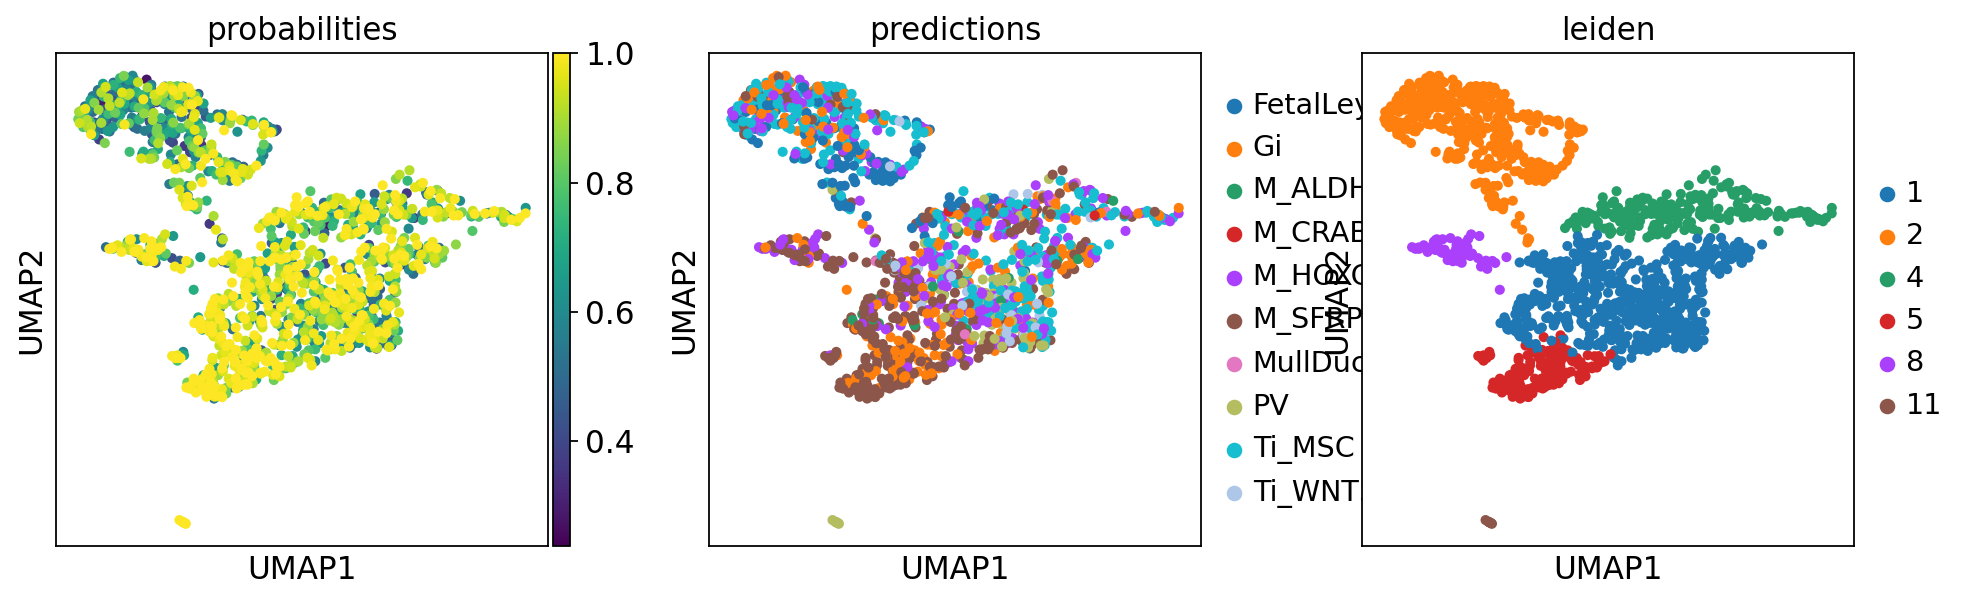

In [28]:
sn_adata.obs['probabilities'] = probs_adata
sc.pl.umap(sn_adata, color=['probabilities',  'predictions'])
sc.pl.umap(sn_adata, color=['probabilities',  'predictions', 'leiden'])

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


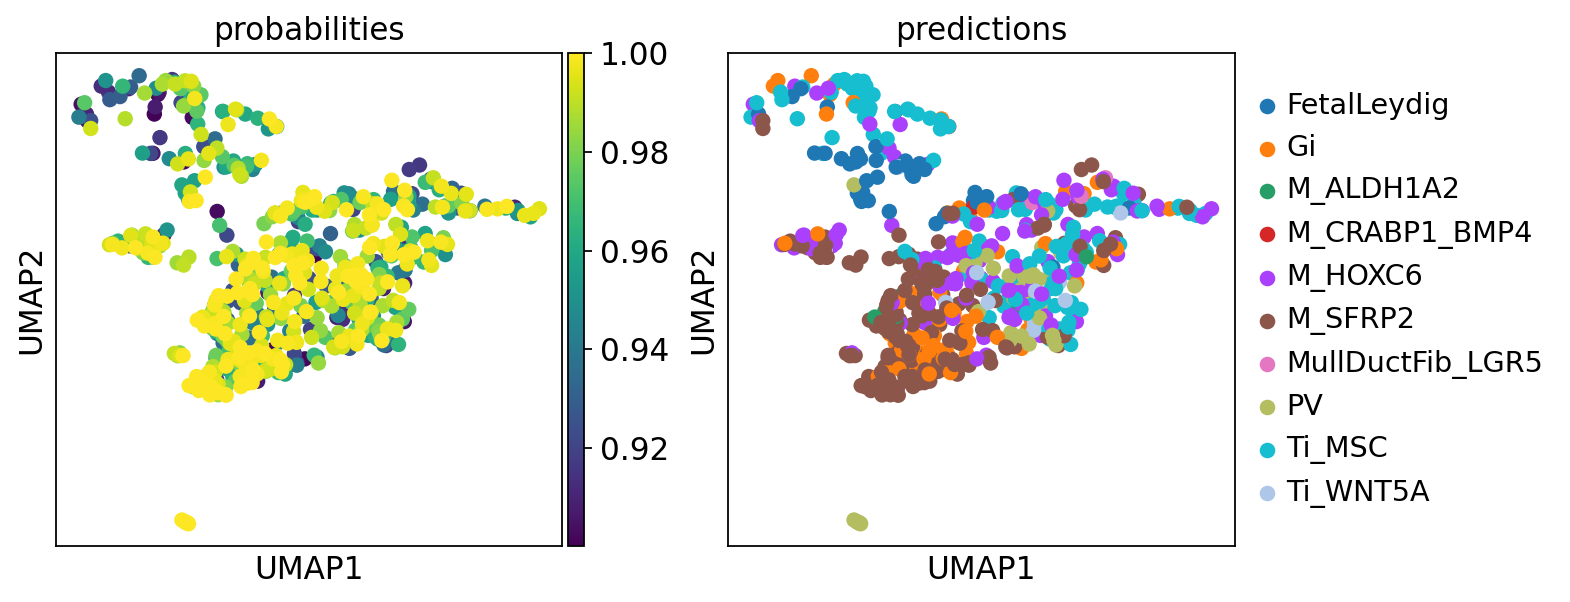

In [29]:
sc.pl.umap(sn_adata[[ i > 0.9 for i in sn_adata.obs['probabilities']  ]], color=['probabilities',  'predictions'])

In [30]:
pd.DataFrame(sn_adata.obs).to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15_mesenchymal_predictions.csv')

# Zoom in into supporting

In [31]:
meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_annotated.csv')
meta_som = meta_som.set_index('Unnamed: 0')
meta_som.head()

# meta_germ = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotated.csv')
# meta_germ = meta_germ.set_index('Unnamed: 0')
# meta_germ.head()

# meta_mes = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymalPV_annotated.csv')
# meta_mes = meta_mes.set_index('Unnamed: 0')
# meta_mes.head()

cell_annot = meta_som['annotated_clusters'].to_dict()

Trying to set attribute `.obs` of view, copying.


filtered out 9427 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clusters' as categorical


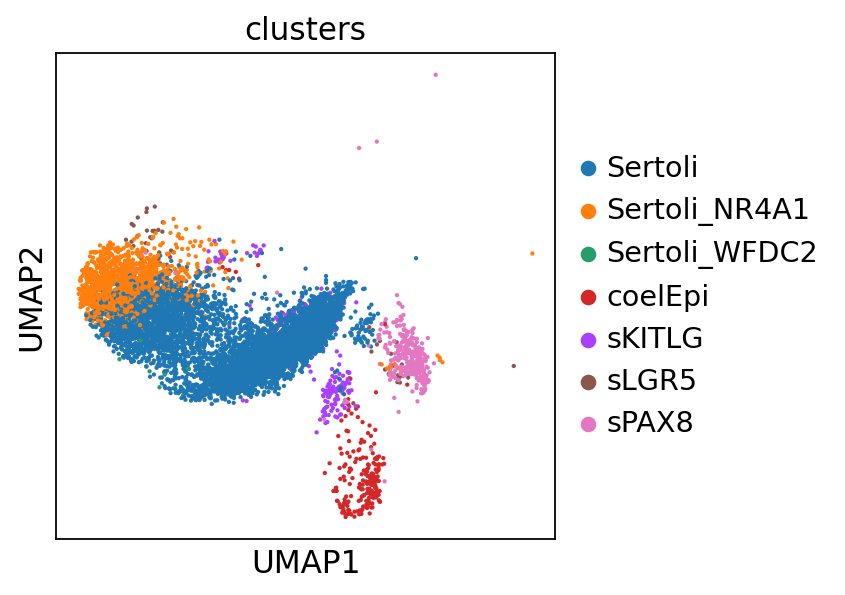

In [32]:
# Subset scRNAref to clusters of interest
sc_adata = anndata.AnnData(X=sc_adataP.raw.X, var=sc_adataP.raw.var, obs=sc_adataP.obs, asview=False)
sc_adata.obsm["X_umap"] = sc_adataP.obsm["X_umap"]

barcodes = meta_som.index.tolist()
sc_adata = sc_adata[[ i in barcodes for i in sc_adata.obs.index]]
sc_adata.obs['clusters'] = sc_adata.obs['clusters'].tolist()
sc_adata.obs['clusters'] = [ cell_annot[i] for i in sc_adata.obs_names ] 
sc_adata = sc_adata[[ 'doublet' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'preGC' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'ovar' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'lowQC' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'cycling' not in i for i in sc_adata.obs['clusters'] ]]

sc.pp.filter_genes(sc_adata, min_cells=5)
sc.pp.normalize_per_cell(sc_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata)
highly_variable_genes = sc_adata.var["highly_variable"]
sc_adata = sc_adata[:, highly_variable_genes]
sc.pp.scale(sc_adata, max_value=10)

sc.pl.umap(sc_adata, color='clusters')

In [33]:
# Subset snRNA to clusters of interest
sn_adata = anndata.AnnData(X=sn_adataR.raw.X, var=sn_adataR.raw.var, obs=sn_adataR.obs, asview=False)
sn_adata.obsm["X_umap"] = sn_adataR.obsm["X_umap"]
sn_adata = sn_adata[[ i in ['0', '3', '6'] for i in sn_adata.obs['leiden'] ]]
sc.pp.filter_genes(sn_adata, min_cells=5)
sc.pp.normalize_per_cell(sn_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sn_adata)
sc.pp.highly_variable_genes(sn_adata)#min_mean=0.0125, min_disp=0.25)
highly_variable_genes = sn_adata.var["highly_variable"]
sn_adata = sn_adata[:, highly_variable_genes]
sc.pp.scale(sn_adata, max_value=10)

filtered out 8771 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
common_genes = list(set(sc_adata.var.index.values).intersection(sn_adata.var.index.values))
print('common genes: ', len(common_genes))
sn_adata = sn_adata[:,common_genes]
sc_adata = sc_adata[:,common_genes]
print(sc_adata.X.shape)
print(sn_adata.X.shape)

common genes:  1053
(7990, 1053)
(1251, 1053)


### Build a regression classifier from the scRef

In [35]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(sc_adata.X, [str(i) for i in sc_adata.obs['clusters'].values])

LogisticRegression(C=0.2, max_iter=10000, n_jobs=-1, random_state=0)

### Classify





In [36]:
predictions = logisticRegr.predict(sn_adata.X)
sn_adata.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(sn_adata.X)
probs_adata = []
for i,clus in enumerate(sn_adata.obs['predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, copying.


## Plot classification

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical
... storing 'predictions' as categorical


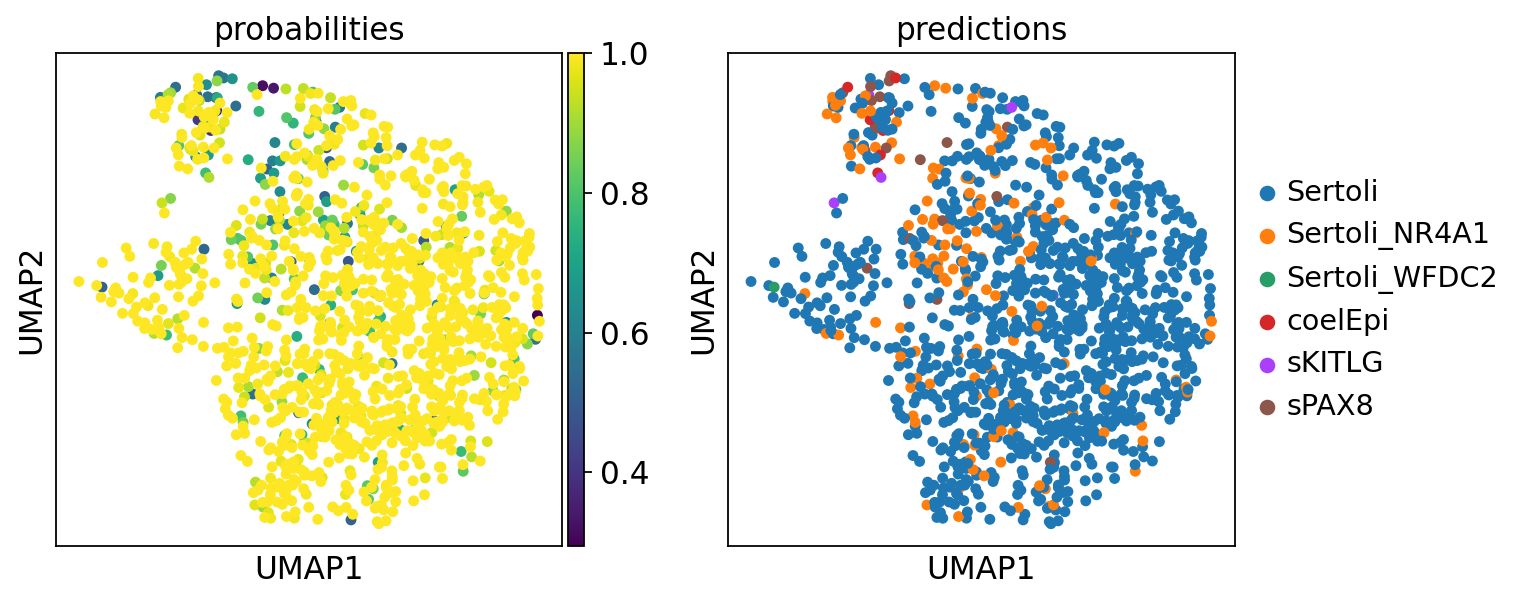

In [37]:
sn_adata.obs['probabilities'] = probs_adata
sc.pl.umap(sn_adata, color=['probabilities',  'predictions'])

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


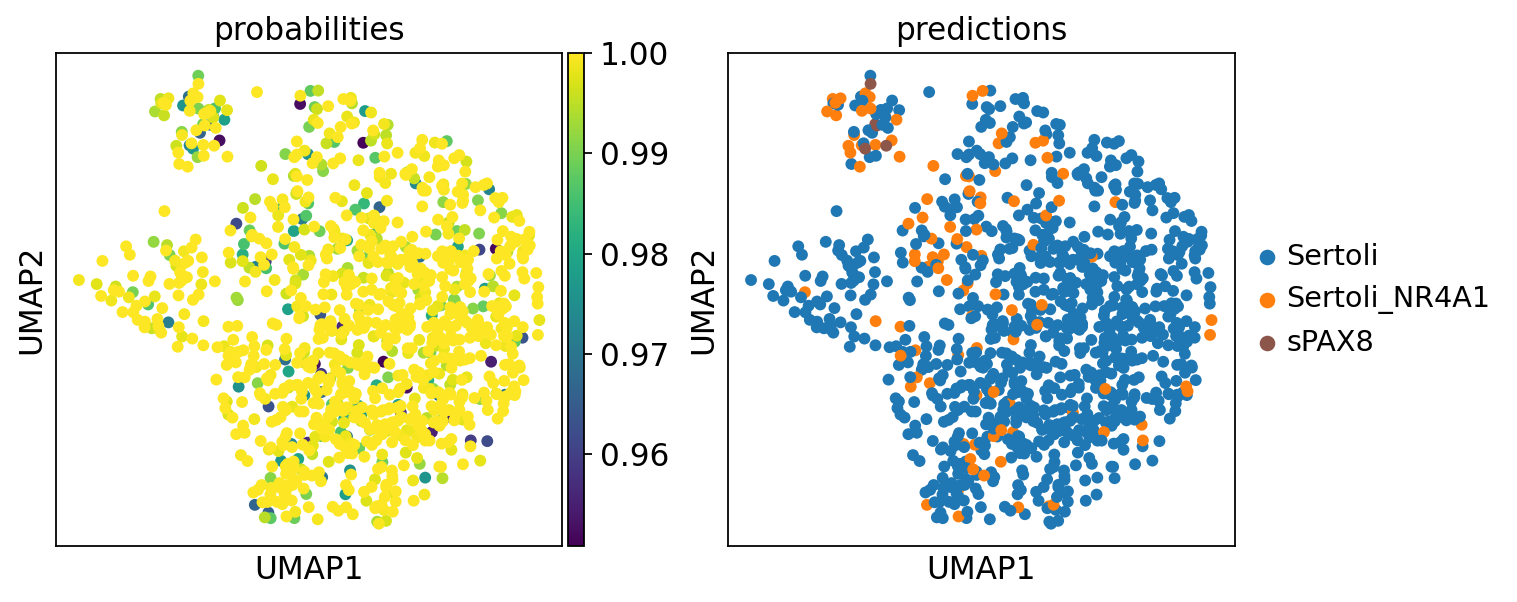

In [38]:
sc.pl.umap(sn_adata[[ i > 0.95 for i in sn_adata.obs['probabilities']  ]], color=['probabilities',  'predictions'])

In [40]:
pd.DataFrame(sn_adata.obs).to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15_supporting_predictions.csv')

# Zoom in into germ cells

In [41]:
# meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_annotated.csv')
# meta_som = meta_som.set_index('Unnamed: 0')
# meta_som.head()

meta_germ = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotated.csv')
meta_germ = meta_germ.set_index('Unnamed: 0')
meta_germ.head()

# meta_mes = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymalPV_annotated.csv')
# meta_mes = meta_mes.set_index('Unnamed: 0')
# meta_mes.head()

cell_annot = meta_germ['annotated_clusters'].to_dict()

Trying to set attribute `.obs` of view, copying.


filtered out 13614 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clusters' as categorical


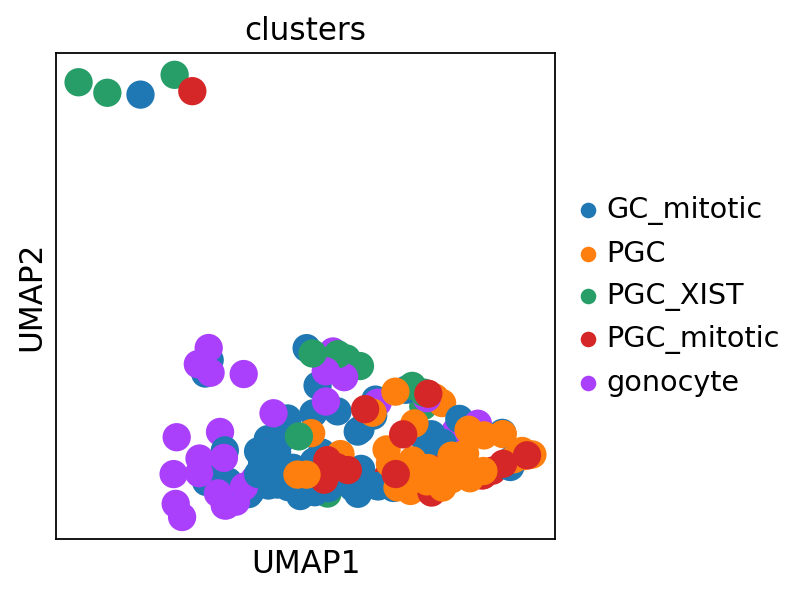

In [42]:
# Subset scRNAref to clusters of interest
sc_adata = anndata.AnnData(X=sc_adataP.raw.X, var=sc_adataP.raw.var, obs=sc_adataP.obs, asview=False)
sc_adata.obsm["X_umap"] = sc_adataP.obsm["X_umap"]

barcodes = meta_germ.index.tolist()
sc_adata = sc_adata[[ i in barcodes for i in sc_adata.obs.index]]
sc_adata.obs['clusters'] = sc_adata.obs['clusters'].tolist()
sc_adata.obs['clusters'] = [ cell_annot[i] for i in sc_adata.obs_names ] 
sc_adata = sc_adata[[ 'doublet' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'oo' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'lowQC' not in i for i in sc_adata.obs['clusters'] ]]
sc_adata = sc_adata[[ 'cycling' not in i for i in sc_adata.obs['clusters'] ]]

sc.pp.filter_genes(sc_adata, min_cells=5)
sc.pp.normalize_per_cell(sc_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sc_adata)
sc.pp.highly_variable_genes(sc_adata)
highly_variable_genes = sc_adata.var["highly_variable"]
sc_adata = sc_adata[:, highly_variable_genes]
sc.pp.scale(sc_adata, max_value=10)

sc.pl.umap(sc_adata, color='clusters')

In [43]:
# Subset snRNA to clusters of interest
sn_adata = anndata.AnnData(X=sn_adataR.raw.X, var=sn_adataR.raw.var, obs=sn_adataR.obs, asview=False)
sn_adata.obsm["X_umap"] = sn_adataR.obsm["X_umap"]
sn_adata = sn_adata[[ i in ['7'] for i in sn_adata.obs['leiden'] ]]
sc.pp.filter_genes(sn_adata, min_cells=5)
sc.pp.normalize_per_cell(sn_adata, counts_per_cell_after=1e4)
sc.pp.log1p(sn_adata)
sc.pp.highly_variable_genes(sn_adata)#min_mean=0.0125, min_disp=0.25)
highly_variable_genes = sn_adata.var["highly_variable"]
sn_adata = sn_adata[:, highly_variable_genes]
sc.pp.scale(sn_adata, max_value=10)

filtered out 14562 genes that are detected in less than 5 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [44]:
common_genes = list(set(sc_adata.var.index.values).intersection(sn_adata.var.index.values))
print('common genes: ', len(common_genes))
sn_adata = sn_adata[:,common_genes]
sc_adata = sc_adata[:,common_genes]
print(sc_adata.X.shape)
print(sn_adata.X.shape)

common genes:  642
(185, 642)
(70, 642)


### Build a regression classifier from the scRef

In [45]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(sc_adata.X, [str(i) for i in sc_adata.obs['clusters'].values])

LogisticRegression(C=0.2, max_iter=10000, n_jobs=-1, random_state=0)

### Classify





In [46]:
predictions = logisticRegr.predict(sn_adata.X)
sn_adata.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(sn_adata.X)
probs_adata = []
for i,clus in enumerate(sn_adata.obs['predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, copying.


## Plot classification

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical
... storing 'predictions' as categorical


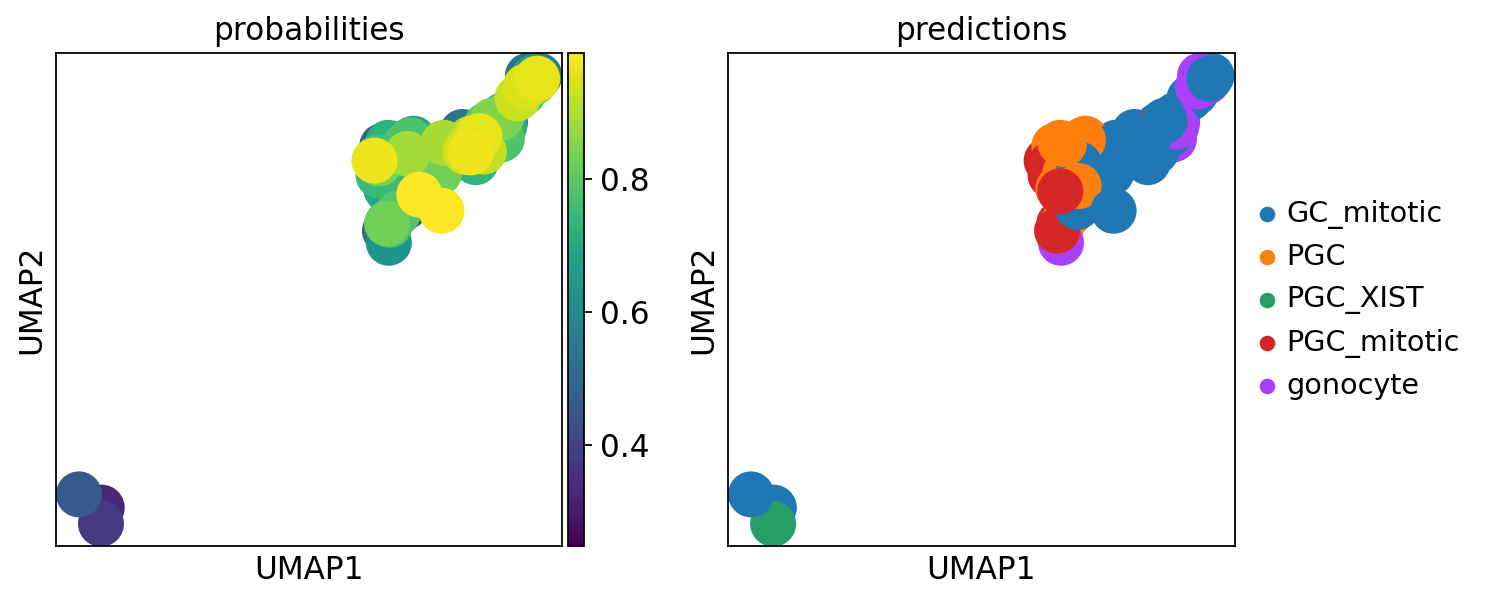

In [47]:
sn_adata.obs['probabilities'] = probs_adata
sc.pl.umap(sn_adata, color=['probabilities',  'predictions'])

/home/jovyan/my-conda-envs/SCanalysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


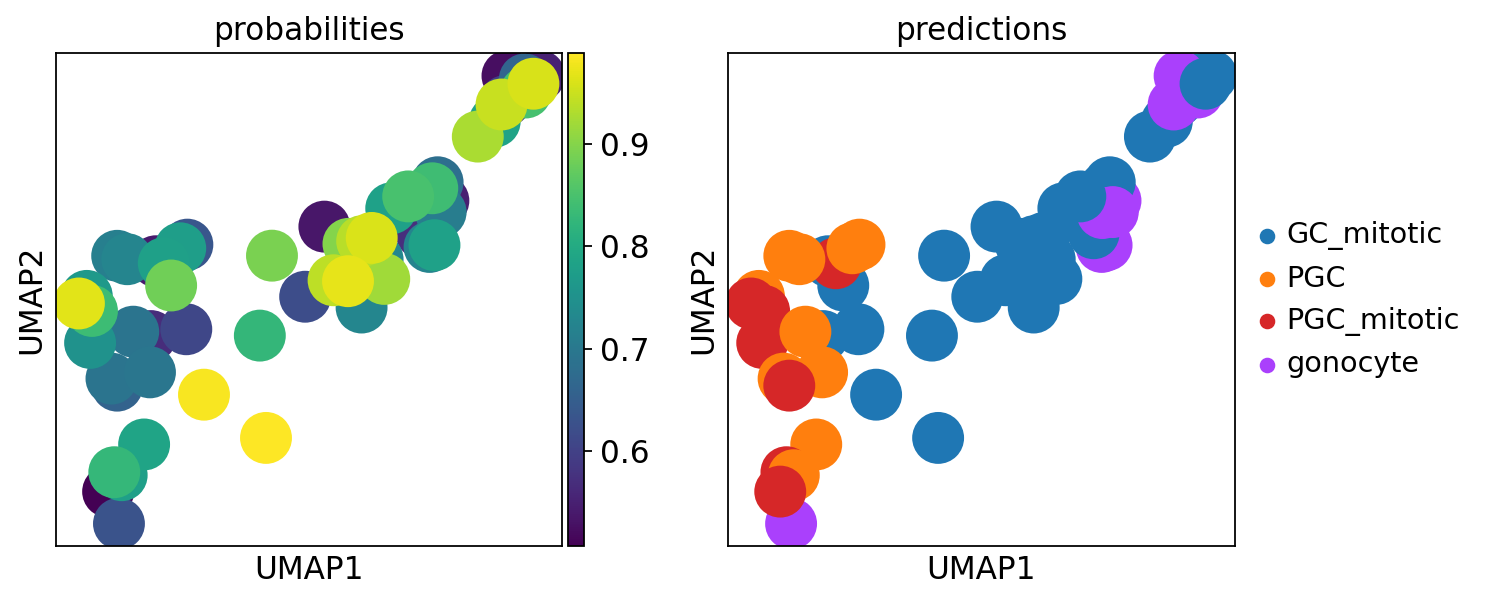

In [48]:
sc.pl.umap(sn_adata[[ i > 0.5 for i in sn_adata.obs['probabilities']  ]], color=['probabilities',  'predictions'])

In [50]:
pd.DataFrame(sn_adata.obs).to_csv('/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_male_Hrv15_germcells_predictions.csv')